In [1]:
from __future__ import print_function
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage
import imutils
import numpy as np
import cv2
import matplotlib.pyplot as plt

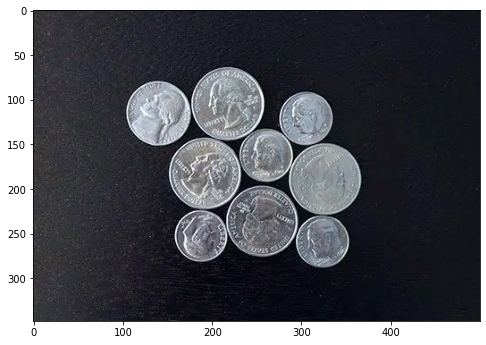

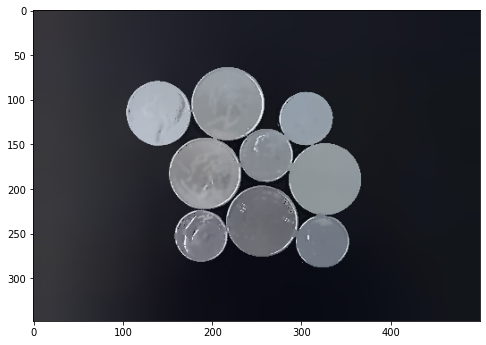

In [2]:
# With basic thresholding and contour extraction
img = cv2.imread('Photos/coin.jpg')
plt.figure("Original Image", figsize=(8, 8))
plt.imshow(img)
plt.show()
# Apply pyramid meanshift filtering => to help the accuracy of the thresholding step below.
# meanshift segmentation of image
shifted = cv2.pyrMeanShiftFiltering(img, 21, 51)
plt.figure("Meanshift Segmentation Image", figsize=(8, 8))
plt.imshow(shifted)
plt.show()

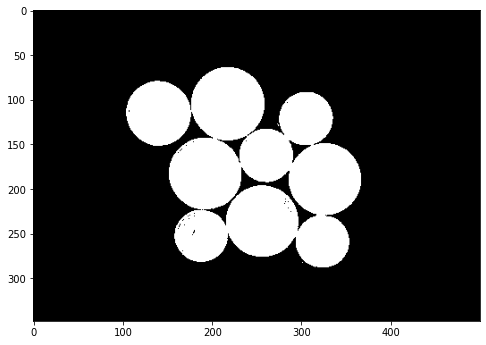

In [4]:
# Convert to grayscale and apply Otsu thresholding => to segment the background from the foreground
gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
plt.figure("Otsu Thresholding", figsize=(8, 8))
plt.imshow(thresh, cmap='gray')
plt.show()

In [5]:
# Detect contours in the thresholded image and draw each individual contour
# find contours in the thresholded image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
print("[INFO] {} unique contours found".format(len(cnts)))

# loop over the contours
for (i, c) in enumerate(cnts):
	# draw the contour
	((x, y), _) = cv2.minEnclosingCircle(c)
	cv2.putText(img, "#{}".format(i + 1), (int(x) - 10, int(y)),
		cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
	cv2.drawContours(img, [c], -1, (0, 255, 0), 2)
# show the output image
cv2.imshow("Image", img)
cv2.waitKey(0)
cv2.destroyAllWindows()

[INFO] 3 unique contours found


In [6]:
# Using Watershed algorithm
# Continue with thresholding image

# now compute the exact Euclidean distance from every binary pixel to the nearest zero pixel, then find peaks in this distance map
D = ndimage.distance_transform_edt(thresh)
localMax = peak_local_max(D, indices=False, min_distance=20, labels=thresh)

# perform a connected component analysis on the local peaks using 8-connectivity 
# then apply Watershed algorithm

markers = ndimage.label(localMax, structure=np.ones((3,3)))[0]
labels = watershed(-D, markers, mask=thresh)
print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))

[INFO] 9 unique segments found


/tmp/ipykernel_7075/2364614163.py:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  localMax = peak_local_max(D, indices=False, min_distance=20, labels=thresh)
/home/vuhta/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


In [8]:
# loop over the unique labels returned by the Watershed algorithm
for label in np.unique(labels):
	# if the label is zero, we are examining the 'background' and ignore it
	if label == 0:
		continue
	# otherwise, allocate memory for the label region and draw
	# it on the mask
	mask = np.zeros(gray.shape, dtype="uint8")
	mask[labels == label] = 255
	# detect contours in the mask and grab the largest one
	cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
		cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key=cv2.contourArea)
	# draw a circle enclosing the object
	((x, y), r) = cv2.minEnclosingCircle(c)
	cv2.circle(img, (int(x), int(y)), int(r), (0, 255, 0), 2)
	cv2.putText(img, "#{}".format(label), (int(x) - 10, int(y)),
		cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
# show the output image
cv2.imshow("Output", img)
cv2.waitKey(0)
cv2.destroyAllWindows()